In [1]:
import wrds
import pandas as pd
pd.set_option('display.max_columns', None)

import os
import sys
from pathlib import Path

# add the src directory to the path in order to import config
current_directory = Path.cwd()
src_path = current_directory.parent / "src"
sys.path.insert(0, str(src_path))

import load_option_data_01 as l1
import filter_option_data_01 as f1
import bsm_pricer as bsm
import config
WRDS_USERNAME = Path(config.WRDS_USERNAME)
DATA_DIR = Path(config.DATA_DIR)
OUTPUT_DIR = Path(config.OUTPUT_DIR)

In [2]:
import numpy as np

In [85]:
import datetime

In [3]:
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.io as pio
# pio.templates.default = "plotly_white"
# pio.renderers.default = "plotly_mimetype"
# from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
check_results = pd.DataFrame(index=pd.MultiIndex.from_product([['Level 3 filters'], ['IV filter', 'Put-call parity filter', 'All']]),
                             columns=pd.MultiIndex.from_product([['Berkeley', 'OptionMetrics'], ['Deleted', 'Remaining']]))
check_results.loc[['Level 3 filters'], ['Berkeley', 'OptionMetrics']] = [[10865, np.nan, 67850, np.nan], [10298, np.nan,46138, np.nan], [np.nan, 173500,np.nan, 962784]]

check_results


Berkeley           OptionMetrics  \
                                        Deleted Remaining       Deleted   
Level 3 filters IV filter                 10865       NaN         67850   
                Put-call parity filter    10298       NaN         46138   
                All                         NaN    173500           NaN   

                                                  
                                       Remaining  
Level 3 filters IV filter                    NaN  
                Put-call parity filter       NaN  
                All                       962784

In [5]:
print(check_results.to_string())

                                       Berkeley           OptionMetrics          
                                        Deleted Remaining       Deleted Remaining
Level 3 filters IV filter                 10865       NaN         67850       NaN
                Put-call parity filter    10298       NaN         46138       NaN
                All                         NaN    173500           NaN    962784


# Level 3 Filters: IV Filter

*Methodology*

The process for construction of the IV filter is as follows:

<ol>

<li> The IV filter removes volatility outliers to reduce the prevalence of apparent butterfly arbitrage. This involves dropping calls and puts that have the same expiration date and strike price, but have anomalous prices due to extreme implied volatility values. 

<li> For each *date* and *maturity*, we fit a quadratic curve to the implied volatility of puts and calls (separately) through the observed log implied volatilities

</ol>

In [6]:
# read in L2 filtered data
l2_data = pd.read_parquet(DATA_DIR / "pulled/data_199601_201201_L2filter.parquet", columns=['secid', 'date', 'exdate', 'cp_flag', 'mnyns', 'impl_volatility', 'tb_m3', 'best_bid', 'best_offer', 'strike_price', 'contract_size', 'sec_price'])
l2_data

,secid,date,exdate,cp_flag,mnyns,impl_volatility,tb_m3,best_bid,best_offer,strike_price,contract_size,sec_price
0,108105.0,1996-01-04,1996-02-17,C,0.922778,NaN,0.0504,48.250,49.250,570.0,100.0,617.70
1,108105.0,1996-01-04,1996-06-22,C,0.963251,0.125173,0.0504,38.500,39.500,595.0,100.0,617.70
2,108105.0,1996-01-04,1996-03-16,C,1.011818,0.103697,0.0504,9.125,9.875,625.0,100.0,617.70
3,108105.0,1996-01-04,1996-03-16,C,0.938967,0.110537,0.0504,41.500,42.500,580.0,100.0,617.70
4,108105.0,1996-01-04,1996-03-16,C,0.906589,NaN,0.0504,59.750,60.750,560.0,100.0,617.70
...,...,...,...,...,...,...,...,...,...,...,...,...
1274099,108105.0,2012-01-31,2012-06-29,P,1.085789,0.158748,0.0006,135.300,138.900,1425.0,100.0,1312.41
1274100,108105.0,2012-01-31,2012-06-29,P,1.104838,0.150582,0.0006,154.900,158.400,1450.0,100.0,1312.41
1274101,108105.0,2012-01-31,2012-06-29,P,1.123887,0.144663,0.0006,176.400,179.800,1475.0,100.0,1312.41
1274102,108105.0,2012-01-31,2012-06-29,P,1.142936,0.137213,0.0006,198.700,202.400,1500.0,100.0,1312.41


In [7]:
# calc log IV 
l2_data['log_iv'] = np.log(l2_data['impl_volatility'])
l2_data

,secid,date,exdate,cp_flag,mnyns,impl_volatility,tb_m3,best_bid,best_offer,strike_price,contract_size,sec_price,log_iv
0,108105.0,1996-01-04,1996-02-17,C,0.922778,NaN,0.0504,48.250,49.250,570.0,100.0,617.70,NaN
1,108105.0,1996-01-04,1996-06-22,C,0.963251,0.125173,0.0504,38.500,39.500,595.0,100.0,617.70,-2.078058
2,108105.0,1996-01-04,1996-03-16,C,1.011818,0.103697,0.0504,9.125,9.875,625.0,100.0,617.70,-2.266282
3,108105.0,1996-01-04,1996-03-16,C,0.938967,0.110537,0.0504,41.500,42.500,580.0,100.0,617.70,-2.202405
4,108105.0,1996-01-04,1996-03-16,C,0.906589,NaN,0.0504,59.750,60.750,560.0,100.0,617.70,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274099,108105.0,2012-01-31,2012-06-29,P,1.085789,0.158748,0.0006,135.300,138.900,1425.0,100.0,1312.41,-1.840437
1274100,108105.0,2012-01-31,2012-06-29,P,1.104838,0.150582,0.0006,154.900,158.400,1450.0,100.0,1312.41,-1.893247
1274101,108105.0,2012-01-31,2012-06-29,P,1.123887,0.144663,0.0006,176.400,179.800,1475.0,100.0,1312.41,-1.933348
1274102,108105.0,2012-01-31,2012-06-29,P,1.142936,0.137213,0.0006,198.700,202.400,1500.0,100.0,1312.41,-1.986221


- The distribution of the log(IV) appears close to normal. We could run a Jarque-Bera test to confirm. 

- Next we fit quadratic curves to each set of calls and puts, grouped by date (`date`) and maturity (`exdate`)

In [8]:
l2_data

,secid,date,exdate,cp_flag,mnyns,impl_volatility,tb_m3,best_bid,best_offer,strike_price,contract_size,sec_price,log_iv
0,108105.0,1996-01-04,1996-02-17,C,0.922778,NaN,0.0504,48.250,49.250,570.0,100.0,617.70,NaN
1,108105.0,1996-01-04,1996-06-22,C,0.963251,0.125173,0.0504,38.500,39.500,595.0,100.0,617.70,-2.078058
2,108105.0,1996-01-04,1996-03-16,C,1.011818,0.103697,0.0504,9.125,9.875,625.0,100.0,617.70,-2.266282
3,108105.0,1996-01-04,1996-03-16,C,0.938967,0.110537,0.0504,41.500,42.500,580.0,100.0,617.70,-2.202405
4,108105.0,1996-01-04,1996-03-16,C,0.906589,NaN,0.0504,59.750,60.750,560.0,100.0,617.70,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274099,108105.0,2012-01-31,2012-06-29,P,1.085789,0.158748,0.0006,135.300,138.900,1425.0,100.0,1312.41,-1.840437
1274100,108105.0,2012-01-31,2012-06-29,P,1.104838,0.150582,0.0006,154.900,158.400,1450.0,100.0,1312.41,-1.893247
1274101,108105.0,2012-01-31,2012-06-29,P,1.123887,0.144663,0.0006,176.400,179.800,1475.0,100.0,1312.41,-1.933348
1274102,108105.0,2012-01-31,2012-06-29,P,1.142936,0.137213,0.0006,198.700,202.400,1500.0,100.0,1312.41,-1.986221


In [9]:
l2_data.isna().sum()

secid                  0
date                   0
exdate                 0
cp_flag                0
mnyns                  0
impl_volatility    60319
tb_m3               9543
best_bid               0
best_offer             0
strike_price           0
contract_size          0
sec_price              0
log_iv             60319
dtype: int64

In [10]:
def fit_and_store_curve(group):
    # Drop rows with NaN in 'moneyness' or 'log_iv'
    group = group.dropna(subset=['mnyns', 'log_iv'])
    if len(group) < 3:  # Need at least 3 points to fit a quadratic curve
        return group
    try:
        # Fit the quadratic curve
        coefficients = np.polyfit(group['mnyns'], group['log_iv'], 2)
        # Calculate fitted values
        group['fitted_iv'] = np.polyval(coefficients, group['mnyns'])
    except np.RankWarning:
        print("Polyfit may be poorly conditioned")
    return group

# Apply the function
l2_data = l2_data.groupby(['date', 'exdate', 'cp_flag']).apply(fit_and_store_curve)


In [11]:
l2_data

secid       date     exdate cp_flag  \
date       exdate     cp_flag                                                   
1996-01-04 1996-01-20 C       20       108105.0 1996-01-04 1996-01-20       C   
                              22       108105.0 1996-01-04 1996-01-20       C   
                              26       108105.0 1996-01-04 1996-01-20       C   
                              41       108105.0 1996-01-04 1996-01-20       C   
                              49       108105.0 1996-01-04 1996-01-20       C   
...                                         ...        ...        ...     ...   
2012-01-31 2012-06-29 P       1274099  108105.0 2012-01-31 2012-06-29       P   
                              1274100  108105.0 2012-01-31 2012-06-29       P   
                              1274101  108105.0 2012-01-31 2012-06-29       P   
                              1274102  108105.0 2012-01-31 2012-06-29       P   
                              1274103  108105.0 2012-01-31 2012-06-29       P   

                                          mnyns  impl_volatility   tb_m3  \
date       exdate     cp_flag                                              
1996-01-04 1996-01-20 C       20       1.036102         0.106867  0.0504   
                              22       1.019913         0.104694  0.0504   
                              26       1.052291         0.120305  0.0504   
                              41       1.003723         0.112168  0.0504   
                              49       0.995629         0.121763  0.0504   
...                                         ...              ...     ...   
2012-01-31 2012-06-29 P       1274099  1.085789         0.158748  0.0006   
                              1274100  1.104838         0.150582  0.0006   
                              1274101  1.123887         0.144663  0.0006   
                              1274102  1.142936         0.137213  0.0006   
                              1274103  1.181033         0.121174  0.0006   

                                       best_bid  best_offer  strike_price  \
date       exdate     cp_flag                                               
1996-01-04 1996-01-20 C       20         0.1875       0.375         640.0   
                              22         1.1875       1.375         630.0   
                              26         0.0625       0.125         650.0   
                              41         4.5000       4.875         620.0   
                              49         7.5000       8.000         615.0   
...                                         ...         ...           ...   
2012-01-31 2012-06-29 P       1274099  135.3000     138.900        1425.0   
                              1274100  154.9000     158.400        1450.0   
                              1274101  176.4000     179.800        1475.0   
                              1274102  198.7000     202.400        1500.0   
                              1274103  246.4000     249.900        1550.0   

                                       contract_size  sec_price    log_iv  \
date       exdate     cp_flag                                               
1996-01-04 1996-01-20 C       20               100.0     617.70 -2.236170   
                              22               100.0     617.70 -2.256713   
                              26               100.0     617.70 -2.117725   
                              41               100.0     617.70 -2.187758   
                              49               100.0     617.70 -2.105679   
...                                              ...        ...       ...   
2012-01-31 2012-06-29 P       1274099          100.0    1312.41 -1.840437   
                              1274100          100.0    1312.41 -1.893247   
                              1274101          100.0    1312.41 -1.933348   
                              1274102          100.0    1312.41 -1.986221   
                              1274103          100.0    1312.41 -2.110528

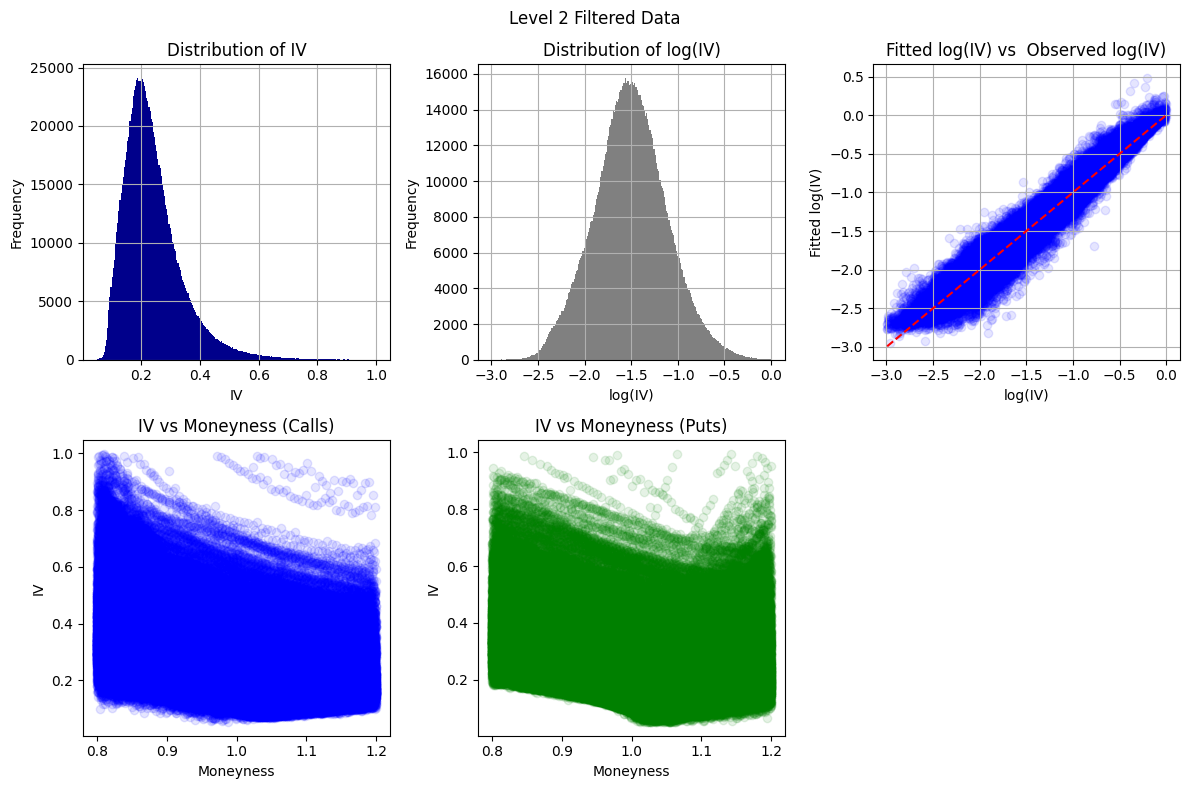

In [28]:
fig, ax = plt.subplots(2,3, figsize=(12,8))

ax[0,0].hist(l2_data['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(l2_data['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# Scatter plot of IV vs fitted IV
ax[0,2].scatter(x=l2_data['log_iv'], y=l2_data['fitted_iv'], color='blue', alpha=0.1)
ax[0,2].set_xlabel('log(IV)')
ax[0,2].set_ylabel('Fitted log(IV)')
ax[0,2].set_title('Fitted log(IV) vs  Observed log(IV)')
# Add 45-deg line
ax[0,2].plot([min(l2_data['log_iv']), max(l2_data['log_iv'])], [min(l2_data['log_iv']), max(l2_data['log_iv'])], color='red', linestyle='--')
ax[0,2].grid()


ax[1,0].scatter(x=l2_data.xs('C', level='cp_flag')['mnyns'], y=np.exp(l2_data.xs('C', level='cp_flag')['log_iv']), color='blue', alpha=0.1, label='IV')
ax[1,0].set_xlabel('Moneyness')
ax[1,0].set_ylabel('IV')
ax[1,0].set_title('IV vs Moneyness (Calls)')

ax[1,1].scatter(x=l2_data.xs('P', level='cp_flag')['mnyns'], y=np.exp(l2_data.xs('P', level='cp_flag')['log_iv']), color='green', alpha=0.1, label='IV')
ax[1,1].set_xlabel('Moneyness')
ax[1,1].set_ylabel('IV')
ax[1,1].set_title('IV vs Moneyness (Puts)')

# Hide ax[1,2]
ax[1,2].axis('off')

plt.suptitle('Level 2 Filtered Data')
plt.tight_layout()
plt.show()

In [29]:
def calc_relative_distance(series1, series2, method='percent'):
    """
    Calculate the relative distance between the implied volatility and the fitted implied volatility.
    
    Parameters:
        method (str): The method to calculate the relative distance. Options are 'percent', 'manhattan', or 'euclidean'.
        
    Returns:
        numpy.ndarray: The relative distance calculated based on the specified method.
        
    Raises:
        ValueError: If the method is not one of 'percent', 'manhattan', or 'euclidean'.
    """
    
    if method == 'percent':
        return (series1 - series2) / series2 * 100
    elif method == 'manhattan':
        return abs(series1 - series2)
    elif method == 'euclidean':
        return np.sqrt((series1 - series2)**2)
    else:
        raise ValueError("Method must be 'percent', 'manhattan', or 'euclidean'")

In [36]:
# Calculate relative distance in percent from the fitted curve
l2_data['rel_distance'] = calc_relative_distance(l2_data['log_iv'], l2_data['fitted_iv'], method='percent')

# Define moneyness bins
bins = np.arange(0.8, 1.21, 0.05)
l2_data['mnyns_bin'] = pd.cut(l2_data['mnyns'], bins=bins)

# Compute standard deviation of relative distances within each moneyness bin
std_devs = l2_data.groupby('mnyns_bin')['rel_distance'].std().reset_index(name='std_dev')


C:\Users\viren\AppData\Local\Temp\ipykernel_15604\2599488818.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_devs = l2_data.groupby('mnyns_bin')['rel_distance'].std().reset_index(name='std_dev')


In [37]:
def mark_outliers(row, std_devs):
    """
    Determines if a data point is an outlier based on its moneyness_bin and relative distance from the fitted curve.
    
    Args:
        row (pandas.Series): A row of data containing the moneyness_bin and rel_distance columns.
        std_devs (pandas.DataFrame): A DataFrame containing the standard deviations for each moneyness_bin.
    
    Returns:
        bool: True if the data point is an outlier, False otherwise.
    """
    
    # Attempt to retrieve the standard deviation for the row's moneyness_bin
    std_dev_row = std_devs.loc[std_devs['mnyns_bin'] == row['mnyns_bin'], 'std_dev']
    
    # Check if std_dev_row is empty (i.e., no matching moneyness_bin was found)
    if not std_dev_row.empty:
        std_dev = std_dev_row.values[0]
        # Calculate how many std_devs away from the fitted curve the IV is
        if abs(row['rel_distance']) > 2 * std_dev:  # Adjust this threshold as needed
            return True
    else:
        # Handle the case where no matching moneyness_bin was found
        return False
    return False


In [38]:
# Apply the function to mark outliers
l2_data['is_outlier'] = l2_data.apply(mark_outliers, axis=1, std_devs=std_devs)


In [39]:
l3_data_iv_only = l2_data[~l2_data['is_outlier']]
l3_data_iv_only

secid       date     exdate cp_flag  \
date       exdate     cp_flag                                                   
1996-01-04 1996-01-20 C       20       108105.0 1996-01-04 1996-01-20       C   
                              22       108105.0 1996-01-04 1996-01-20       C   
                              26       108105.0 1996-01-04 1996-01-20       C   
                              41       108105.0 1996-01-04 1996-01-20       C   
                              51       108105.0 1996-01-04 1996-01-20       C   
...                                         ...        ...        ...     ...   
2012-01-31 2012-06-29 P       1274099  108105.0 2012-01-31 2012-06-29       P   
                              1274100  108105.0 2012-01-31 2012-06-29       P   
                              1274101  108105.0 2012-01-31 2012-06-29       P   
                              1274102  108105.0 2012-01-31 2012-06-29       P   
                              1274103  108105.0 2012-01-31 2012-06-29       P   

                                          mnyns  impl_volatility   tb_m3  \
date       exdate     cp_flag                                              
1996-01-04 1996-01-20 C       20       1.036102         0.106867  0.0504   
                              22       1.019913         0.104694  0.0504   
                              26       1.052291         0.120305  0.0504   
                              41       1.003723         0.112168  0.0504   
                              51       1.028007         0.108615  0.0504   
...                                         ...              ...     ...   
2012-01-31 2012-06-29 P       1274099  1.085789         0.158748  0.0006   
                              1274100  1.104838         0.150582  0.0006   
                              1274101  1.123887         0.144663  0.0006   
                              1274102  1.142936         0.137213  0.0006   
                              1274103  1.181033         0.121174  0.0006   

                                       best_bid  best_offer  strike_price  \
date       exdate     cp_flag                                               
1996-01-04 1996-01-20 C       20         0.1875       0.375         640.0   
                              22         1.1875       1.375         630.0   
                              26         0.0625       0.125         650.0   
                              41         4.5000       4.875         620.0   
                              51         0.6250       0.750         635.0   
...                                         ...         ...           ...   
2012-01-31 2012-06-29 P       1274099  135.3000     138.900        1425.0   
                              1274100  154.9000     158.400        1450.0   
                              1274101  176.4000     179.800        1475.0   
                              1274102  198.7000     202.400        1500.0   
                              1274103  246.4000     249.900        1550.0   

                                       contract_size  sec_price    log_iv  \
date       exdate     cp_flag                                               
1996-01-04 1996-01-20 C       20               100.0     617.70 -2.236170   
                              22               100.0     617.70 -2.256713   
                              26               100.0     617.70 -2.117725   
                              41               100.0     617.70 -2.187758   
                              51               100.0     617.70 -2.219946   
...                                              ...        ...       ...   
2012-01-31 2012-06-29 P       1274099          100.0    1312.41 -1.840437   
                              1274100          100.0    1312.41 -1.893247   
                              1274101          100.0    1312.41 -1.933348   
                              1274102          100.0    1312.41 -1.986221   
                              1274103          100.0    1312.41 -2.110528

In [40]:
len(l2_data)-len(l3_data_iv_only)

66276

In [41]:
final_result = check_results.loc[:,'OptionMetrics'].copy(deep=True)
final_result.loc[('Level 3 filters', 'IV filter'), 'Deleted'] = len(l2_data)-len(l3_data_iv_only)
final_result

Deleted Remaining
Level 3 filters IV filter                66276       NaN
                Put-call parity filter   46138       NaN
                All                        NaN    962784

In [94]:
l3_data = l3_data_iv_only.copy(deep=True)
# convert mnyns_bin to string
l3_data['mnyns_bin'] = l3_data['mnyns_bin'].astype(str)
l3_data.to_parquet(DATA_DIR / "pulled/data_199601_201201_L3filterIVonly.parquet")
l3_data

secid       date     exdate cp_flag  \
date       exdate     cp_flag                                                   
1996-01-04 1996-01-20 C       20       108105.0 1996-01-04 1996-01-20       C   
                              22       108105.0 1996-01-04 1996-01-20       C   
                              26       108105.0 1996-01-04 1996-01-20       C   
                              41       108105.0 1996-01-04 1996-01-20       C   
                              51       108105.0 1996-01-04 1996-01-20       C   
...                                         ...        ...        ...     ...   
2012-01-31 2012-06-29 P       1274099  108105.0 2012-01-31 2012-06-29       P   
                              1274100  108105.0 2012-01-31 2012-06-29       P   
                              1274101  108105.0 2012-01-31 2012-06-29       P   
                              1274102  108105.0 2012-01-31 2012-06-29       P   
                              1274103  108105.0 2012-01-31 2012-06-29       P   

                                          mnyns  impl_volatility   tb_m3  \
date       exdate     cp_flag                                              
1996-01-04 1996-01-20 C       20       1.036102         0.106867  0.0504   
                              22       1.019913         0.104694  0.0504   
                              26       1.052291         0.120305  0.0504   
                              41       1.003723         0.112168  0.0504   
                              51       1.028007         0.108615  0.0504   
...                                         ...              ...     ...   
2012-01-31 2012-06-29 P       1274099  1.085789         0.158748  0.0006   
                              1274100  1.104838         0.150582  0.0006   
                              1274101  1.123887         0.144663  0.0006   
                              1274102  1.142936         0.137213  0.0006   
                              1274103  1.181033         0.121174  0.0006   

                                       best_bid  best_offer  strike_price  \
date       exdate     cp_flag                                               
1996-01-04 1996-01-20 C       20         0.1875       0.375         640.0   
                              22         1.1875       1.375         630.0   
                              26         0.0625       0.125         650.0   
                              41         4.5000       4.875         620.0   
                              51         0.6250       0.750         635.0   
...                                         ...         ...           ...   
2012-01-31 2012-06-29 P       1274099  135.3000     138.900        1425.0   
                              1274100  154.9000     158.400        1450.0   
                              1274101  176.4000     179.800        1475.0   
                              1274102  198.7000     202.400        1500.0   
                              1274103  246.4000     249.900        1550.0   

                                       contract_size  sec_price    log_iv  \
date       exdate     cp_flag                                               
1996-01-04 1996-01-20 C       20               100.0     617.70 -2.236170   
                              22               100.0     617.70 -2.256713   
                              26               100.0     617.70 -2.117725   
                              41               100.0     617.70 -2.187758   
                              51               100.0     617.70 -2.219946   
...                                              ...        ...       ...   
2012-01-31 2012-06-29 P       1274099          100.0    1312.41 -1.840437   
                              1274100          100.0    1312.41 -1.893247   
                              1274101          100.0    1312.41 -1.933348   
                              1274102          100.0    1312.41 -1.986221   
                              1274103          100.0    1312.41 -2.110528

# Level 3 filter: Put-Call Parity

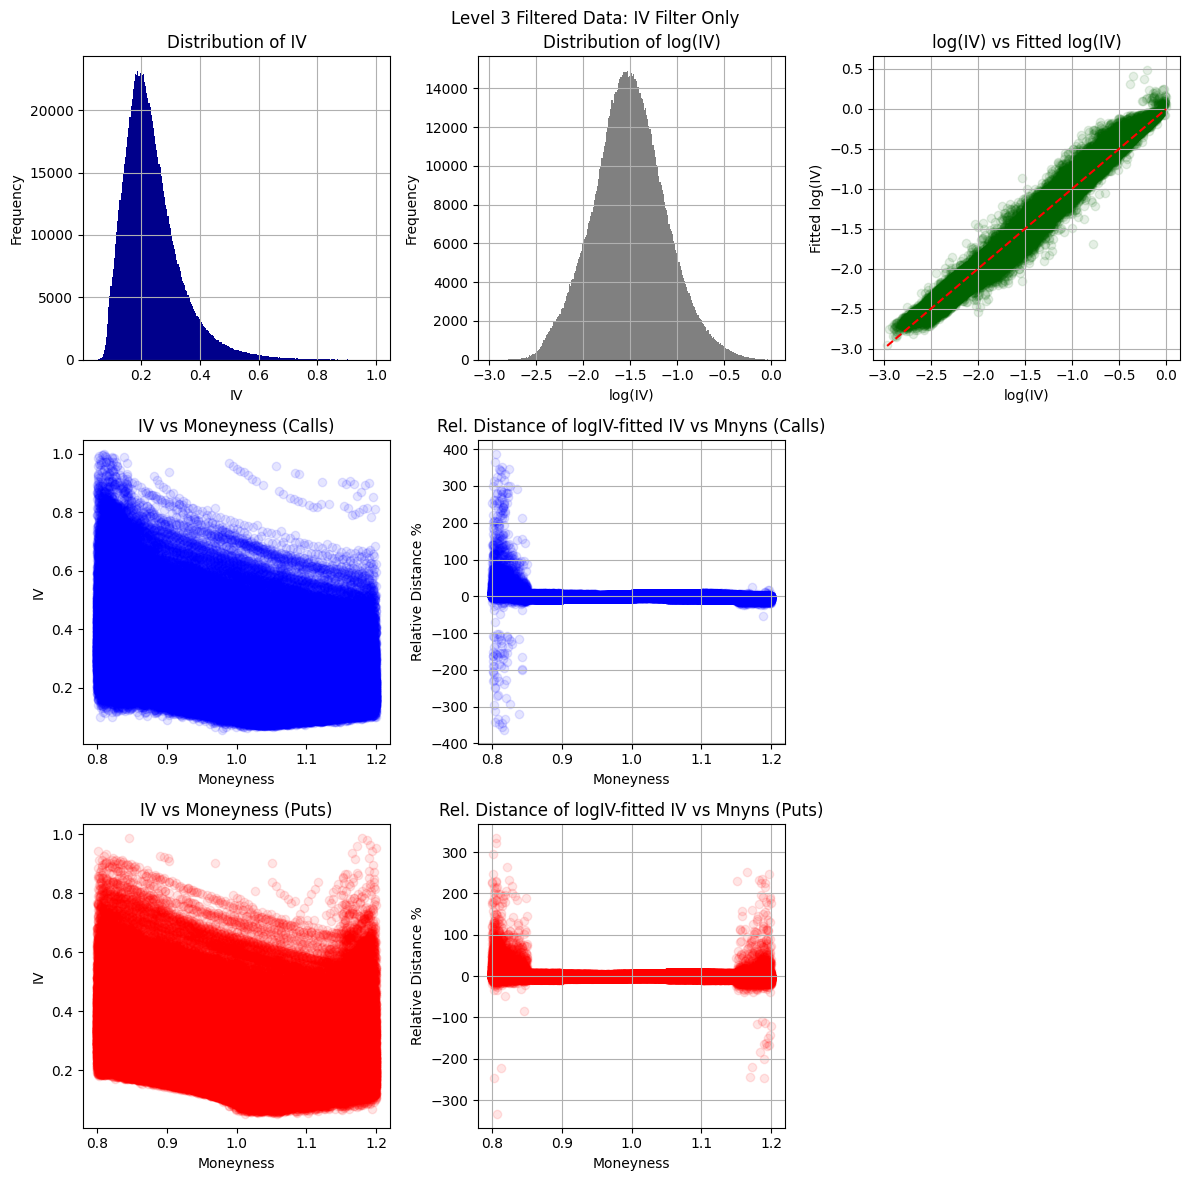

In [43]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

ax[0,0].hist(l3_data['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(l3_data['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# Scatter plot with x=log_iv and y=fitted_iv
ax[0,2].scatter(x=l3_data['log_iv'], y=l3_data['fitted_iv'], color='darkgreen', alpha=0.1)
ax[0,2].set_xlabel('log(IV)')
ax[0,2].set_ylabel('Fitted log(IV)')
ax[0,2].set_title('log(IV) vs Fitted log(IV)')
# Add a 45-degree line
ax[0,2].plot([min(l3_data['log_iv']), max(l3_data['log_iv'])], [min(l3_data['log_iv']), max(l3_data['log_iv'])], color='red', linestyle='--')
ax[0,2].grid()


ax[1,0].scatter(x=l3_data.xs('C', level='cp_flag')['mnyns'], y=np.exp(l3_data.xs('C', level='cp_flag')['log_iv']), color='blue', alpha=0.1, label='IV')
ax[1,0].set_xlabel('Moneyness')
ax[1,0].set_ylabel('IV')
ax[1,0].set_title('IV vs Moneyness (Calls)')

ax[2,0].scatter(x=l3_data.xs('P', level='cp_flag')['mnyns'], y=np.exp(l3_data.xs('P', level='cp_flag')['log_iv']), color='red', alpha=0.1, label='IV')
ax[2,0].set_xlabel('Moneyness')
ax[2,0].set_ylabel('IV')
ax[2,0].set_title('IV vs Moneyness (Puts)')


ax[1,1].scatter(x=l3_data.xs('C', level='cp_flag')['mnyns'], y=l3_data.xs('C', level='cp_flag')['rel_distance'], color='blue', alpha=0.1, label='Calls')
ax[1,1].set_xlabel('Moneyness')
ax[1,1].set_ylabel('Relative Distance %')
ax[1,1].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Calls)')
ax[1,1].grid()

ax[2,1].scatter(x=l3_data.xs('P', level='cp_flag')['mnyns'], y=l3_data.xs('P', level='cp_flag')['rel_distance'], color='red', alpha=0.1, label='Puts')
ax[2,1].set_xlabel('Moneyness')
ax[2,1].set_ylabel('Relative Distance %')
ax[2,1].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Puts)')
ax[2,1].grid()

# hide unused subplots
ax[1,2].axis('off')
ax[2,2].axis('off')

plt.suptitle('Level 3 Filtered Data: IV Filter Only')
plt.tight_layout()
plt.show()

In [50]:
l3_data[(l3_data['mnyns'] < 1.1) & (l3_data['mnyns'] > 0.9)].describe()

,secid,date,exdate,mnyns,impl_volatility,tb_m3,best_bid,best_offer,strike_price,contract_size,sec_price,log_iv,fitted_iv,rel_distance,mid_price
count,737658.0,737658,737658,737658.000000,737658.000000,732320.000000,737658.000000,737658.000000,737658.000000,737658.0,737658.000000,737658.000000,737608.000000,737608.000000,737658.000000
mean,108105.0,2005-10-09 01:07:01.805226624,2005-12-11 06:44:16.157731328,0.997488,0.212824,0.024526,43.866117,45.790408,1168.744688,100.0,1171.732808,-1.610898,-1.610036,-0.012920,44.828262
min,108105.0,1996-01-04 00:00:00,1996-01-20 00:00:00,0.900002,0.051538,0.000000,0.050000,0.100000,540.000000,100.0,598.480000,-2.965436,-2.951875,-7.498260,0.075000
25%,108105.0,2001-09-24 00:00:00,2001-11-17 00:00:00,0.954165,0.159078,0.001600,13.000000,14.400000,1035.000000,100.0,1059.790000,-1.838361,-1.833261,-1.007391,13.700000
50%,108105.0,2007-02-09 00:00:00,2007-03-30 00:00:00,0.997156,0.201763,0.018200,34.700000,36.900000,1195.000000,100.0,1197.660000,-1.600662,-1.600722,-0.027040,35.800000
75%,108105.0,2009-11-10 00:00:00,2010-01-16 00:00:00,1.040071,0.248124,0.048100,67.900000,70.500000,1325.000000,100.0,1320.650000,-1.393827,-1.400346,0.895691,69.200000
max,108105.0,2012-01-31 00:00:00,2012-06-29 00:00:00,1.099997,0.967969,0.062400,232.000000,234.000000,1710.000000,100.0,1565.150000,-0.032555,-0.032860,7.498119,233.000000
std,0.0,NaN,NaN,0.053355,0.080536,0.021192,36.715675,37.347691,219.523252,0.0,211.501285,0.353625,0.346848,2.046572,37.028136


In [52]:
l3_data[(l3_data['mnyns'] > 1.1) | (l3_data['mnyns'] < 0.9)].describe()

,secid,date,exdate,mnyns,impl_volatility,tb_m3,best_bid,best_offer,strike_price,contract_size,sec_price,log_iv,fitted_iv,rel_distance,mid_price
count,409851.0,409851,409851,409851.000000,409851.000000,406656.000000,409851.000000,409851.000000,409851.000000,409851.0,409851.000000,409851.000000,409800.000000,409800.000000,409851.000000
mean,108105.0,2006-10-22 16:49:34.926985472,2006-12-31 10:53:28.871516672,0.954883,0.287207,0.018726,87.000736,88.851103,1107.505679,100.0,1162.221200,-1.315312,-1.315807,0.504537,87.925920
min,108105.0,1996-01-04 00:00:00,1996-01-20 00:00:00,0.800000,0.055424,0.000000,0.050000,0.100000,500.000000,100.0,598.480000,-2.892743,-2.746241,-363.173617,0.075000
25%,108105.0,2003-04-21 00:00:00,2003-06-21 00:00:00,0.843702,0.207668,0.001300,2.400000,3.200000,950.000000,100.0,1050.470000,-1.571815,-1.579136,-1.163169,2.800000
50%,108105.0,2008-07-08 00:00:00,2008-09-20 00:00:00,0.880330,0.272690,0.009500,25.625000,28.625000,1090.000000,100.0,1174.170000,-1.299420,-1.302586,-0.014738,27.125000
75%,108105.0,2010-06-03 00:00:00,2010-08-21 00:00:00,1.120040,0.340347,0.040500,167.800000,170.600000,1260.000000,100.0,1308.040000,-1.077790,-1.071365,1.085924,169.200000
max,108105.0,2012-01-31 00:00:00,2012-06-29 00:00:00,1.199995,0.999066,0.062400,357.875000,359.875000,1800.000000,100.0,1565.150000,-0.000934,0.485101,386.609890,358.875000
std,0.0,NaN,NaN,0.140464,0.109575,0.020409,89.222355,90.077626,236.994977,0.0,196.368262,0.368105,0.378643,7.951819,89.648198


In [53]:
# calculate bid-ask midpoint
l3_data['mid_price'] = (l3_data['best_bid'] + l3_data['best_offer']) / 2
l3_data

secid       date     exdate cp_flag  \
date       exdate     cp_flag                                                   
1996-01-04 1996-01-20 C       20       108105.0 1996-01-04 1996-01-20       C   
                              22       108105.0 1996-01-04 1996-01-20       C   
                              26       108105.0 1996-01-04 1996-01-20       C   
                              41       108105.0 1996-01-04 1996-01-20       C   
                              51       108105.0 1996-01-04 1996-01-20       C   
...                                         ...        ...        ...     ...   
2012-01-31 2012-06-29 P       1274099  108105.0 2012-01-31 2012-06-29       P   
                              1274100  108105.0 2012-01-31 2012-06-29       P   
                              1274101  108105.0 2012-01-31 2012-06-29       P   
                              1274102  108105.0 2012-01-31 2012-06-29       P   
                              1274103  108105.0 2012-01-31 2012-06-29       P   

                                          mnyns  impl_volatility   tb_m3  \
date       exdate     cp_flag                                              
1996-01-04 1996-01-20 C       20       1.036102         0.106867  0.0504   
                              22       1.019913         0.104694  0.0504   
                              26       1.052291         0.120305  0.0504   
                              41       1.003723         0.112168  0.0504   
                              51       1.028007         0.108615  0.0504   
...                                         ...              ...     ...   
2012-01-31 2012-06-29 P       1274099  1.085789         0.158748  0.0006   
                              1274100  1.104838         0.150582  0.0006   
                              1274101  1.123887         0.144663  0.0006   
                              1274102  1.142936         0.137213  0.0006   
                              1274103  1.181033         0.121174  0.0006   

                                       best_bid  best_offer  strike_price  \
date       exdate     cp_flag                                               
1996-01-04 1996-01-20 C       20         0.1875       0.375         640.0   
                              22         1.1875       1.375         630.0   
                              26         0.0625       0.125         650.0   
                              41         4.5000       4.875         620.0   
                              51         0.6250       0.750         635.0   
...                                         ...         ...           ...   
2012-01-31 2012-06-29 P       1274099  135.3000     138.900        1425.0   
                              1274100  154.9000     158.400        1450.0   
                              1274101  176.4000     179.800        1475.0   
                              1274102  198.7000     202.400        1500.0   
                              1274103  246.4000     249.900        1550.0   

                                       contract_size  sec_price    log_iv  \
date       exdate     cp_flag                                               
1996-01-04 1996-01-20 C       20               100.0     617.70 -2.236170   
                              22               100.0     617.70 -2.256713   
                              26               100.0     617.70 -2.117725   
                              41               100.0     617.70 -2.187758   
                              51               100.0     617.70 -2.219946   
...                                              ...        ...       ...   
2012-01-31 2012-06-29 P       1274099          100.0    1312.41 -1.840437   
                              1274100          100.0    1312.41 -1.893247   
                              1274101          100.0    1312.41 -1.933348   
                              1274102          100.0    1312.41 -1.986221   
                              1274103          100.0    1312.41 -2.110528

- Next we match put-call pairs. To do this, we need to ensure that for each call option, there's a corresponding put option with the same *strike price* and *expiration date*. 

In [54]:
# extract all the call options
call_options = l3_data.xs('C', level='cp_flag')
call_options

secid       date     exdate cp_flag  \
date       exdate                                                      
1996-01-04 1996-01-20 20      108105.0 1996-01-04 1996-01-20       C   
                      22      108105.0 1996-01-04 1996-01-20       C   
                      26      108105.0 1996-01-04 1996-01-20       C   
                      41      108105.0 1996-01-04 1996-01-20       C   
                      51      108105.0 1996-01-04 1996-01-20       C   
...                                ...        ...        ...     ...   
2012-01-31 2012-06-29 624591  108105.0 2012-01-31 2012-06-29       C   
                      624592  108105.0 2012-01-31 2012-06-29       C   
                      624593  108105.0 2012-01-31 2012-06-29       C   
                      624594  108105.0 2012-01-31 2012-06-29       C   
                      624595  108105.0 2012-01-31 2012-06-29       C   

                                 mnyns  impl_volatility   tb_m3  best_bid  \
date       exdate                                                           
1996-01-04 1996-01-20 20      1.036102         0.106867  0.0504    0.1875   
                      22      1.019913         0.104694  0.0504    1.1875   
                      26      1.052291         0.120305  0.0504    0.0625   
                      41      1.003723         0.112168  0.0504    4.5000   
                      51      1.028007         0.108615  0.0504    0.6250   
...                                ...              ...     ...       ...   
2012-01-31 2012-06-29 624591  1.085789         0.158147  0.0006   13.1000   
                      624592  1.104838         0.152500  0.0006    8.1000   
                      624593  1.123887         0.147193  0.0006    4.8000   
                      624594  1.142936         0.143243  0.0006    2.8000   
                      624595  1.181033         0.138542  0.0006    0.9500   

                              best_offer  strike_price  contract_size  \
date       exdate                                                       
1996-01-04 1996-01-20 20           0.375         640.0          100.0   
                      22           1.375         630.0          100.0   
                      26           0.125         650.0          100.0   
                      41           4.875         620.0          100.0   
                      51           0.750         635.0          100.0   
...                                  ...           ...            ...   
2012-01-31 2012-06-29 624591      15.000        1425.0          100.0   
                      624592      10.200        1450.0          100.0   
                      624593       6.500        1475.0          100.0   
                      624594       4.000        1500.0          100.0   
                      624595       1.400        1550.0          100.0   

                              sec_price    log_iv  fitted_iv  rel_distance  \
date       exdate                                                            
1996-01-04 1996-01-20 20         617.70 -2.236170  -2.197458      1.761703   
                      22         617.70 -2.256713  -2.231466      1.131443   
                      26         617.70 -2.117725  -2.131616     -0.651647   
                      41         617.70 -2.187758  -2.233640     -2.054168   
                      51         617.70 -2.219946  -2.218441      0.067838   
...                                 ...       ...        ...           ...   
2012-01-31 2012-06-29 624591    1312.41 -1.844230  -1.821306      1.258667   
                      624592    1312.41 -1.880591  -1.861184      1.042714   
                      624593    1312.41 -1.916011  -1.900864      0.796822   
                      624594    1312.41 -1.943213  -1.940347      0.147700   
                      624595    1312.41 -1.976582  -2.018720     -2.087375   

                                mnyns_bin  is_outlier  mid_price  
date       exdate                                             

In [55]:
# extract all the put options
put_options = l3_data.xs('P', level='cp_flag')
put_options

secid       date     exdate cp_flag  \
date       exdate                                                       
1996-01-04 1996-01-20 624603   108105.0 1996-01-04 1996-01-20       P   
                      624604   108105.0 1996-01-04 1996-01-20       P   
                      624615   108105.0 1996-01-04 1996-01-20       P   
                      624624   108105.0 1996-01-04 1996-01-20       P   
                      624637   108105.0 1996-01-04 1996-01-20       P   
...                                 ...        ...        ...     ...   
2012-01-31 2012-06-29 1274099  108105.0 2012-01-31 2012-06-29       P   
                      1274100  108105.0 2012-01-31 2012-06-29       P   
                      1274101  108105.0 2012-01-31 2012-06-29       P   
                      1274102  108105.0 2012-01-31 2012-06-29       P   
                      1274103  108105.0 2012-01-31 2012-06-29       P   

                                  mnyns  impl_volatility   tb_m3  best_bid  \
date       exdate                                                            
1996-01-04 1996-01-20 624603   0.963251         0.181116  0.0504    1.3750   
                      624604   0.955156         0.191383  0.0504    1.0000   
                      624615   0.898494         0.261797  0.0504    0.1250   
                      624624   0.890400         0.273457  0.0504    0.1250   
                      624637   0.906589         0.253956  0.0504    0.1875   
...                                 ...              ...     ...       ...   
2012-01-31 2012-06-29 1274099  1.085789         0.158748  0.0006  135.3000   
                      1274100  1.104838         0.150582  0.0006  154.9000   
                      1274101  1.123887         0.144663  0.0006  176.4000   
                      1274102  1.142936         0.137213  0.0006  198.7000   
                      1274103  1.181033         0.121174  0.0006  246.4000   

                               best_offer  strike_price  contract_size  \
date       exdate                                                        
1996-01-04 1996-01-20 624603       1.6250         595.0          100.0   
                      624604       1.2500         590.0          100.0   
                      624615       0.2500         555.0          100.0   
                      624624       0.1875         550.0          100.0   
                      624637       0.3125         560.0          100.0   
...                                   ...           ...            ...   
2012-01-31 2012-06-29 1274099    138.9000        1425.0          100.0   
                      1274100    158.4000        1450.0          100.0   
                      1274101    179.8000        1475.0          100.0   
                      1274102    202.4000        1500.0          100.0   
                      1274103    249.9000        1550.0          100.0   

                               sec_price    log_iv  fitted_iv  rel_distance  \
date       exdate                                                             
1996-01-04 1996-01-20 624603      617.70 -1.708618  -1.753738     -2.572836   
                      624604      617.70 -1.653479  -1.722393     -4.001067   
                      624615      617.70 -1.340186  -1.349431     -0.685122   
                      624624      617.70 -1.296611  -1.274216      1.757516   
                      624637      617.70 -1.370594  -1.419162     -3.422302   
...                                  ...       ...        ...           ...   
2012-01-31 2012-06-29 1274099    1312.41 -1.840437  -1.846570     -0.332141   
                      1274100    1312.41 -1.893247  -1.895561     -0.122030   
                      1274101    1312.41 -1.933348  -1.945440     -0.621552   
                      1274102    1312.41 -1.986221  -1.996209     -0.500380   
                      1274103    1312.41 -2.110528  -2.100416      0.481406   

                                 mnyns_bin  is_outlier  mid_price  
date      

In [72]:
def build_put_call_pairs(call_options, put_options):
    """
    Builds pairs of call and put options based on the same date, expiration date, and moneyness.

    Args:
        call_options (DataFrame): DataFrame containing call options data.
        put_options (DataFrame): DataFrame containing put options data.

    Returns:
        tuple of (matching_calls: pd.DataFrame, matching_puts: pd.DataFrame)
    """
    call_options.set_index(['date', 'exdate', 'mnyns'], inplace=True)
    put_options.set_index(['date', 'exdate', 'mnyns'], inplace=True)
    
    # get common indices
    common_index = call_options.index.intersection(put_options.index)

    # Extract the matching entries
    matching_calls = call_options.loc[common_index]
    matching_puts = put_options.loc[common_index]
    
    result = (matching_calls, matching_puts)

    return result

In [75]:
matching_calls, matching_puts = build_put_call_pairs(call_options.reset_index(), put_options.reset_index())
matching_calls, matching_puts

(                                   secid cp_flag  impl_volatility   tb_m3  \
 date       exdate     mnyns                                                 
 1996-01-04 1996-01-20 1.019913  108105.0       C         0.104694  0.0504   
                       1.028007  108105.0       C         0.108615  0.0504   
                       0.987534  108105.0       C         0.100806  0.0504   
            1996-02-17 1.036102  108105.0       C         0.106798  0.0504   
                       0.971345  108105.0       C         0.098828  0.0504   
 ...                                  ...     ...              ...     ...   
 2012-01-31 2012-06-29 1.085789  108105.0       C         0.158147  0.0006   
                       1.104838  108105.0       C         0.152500  0.0006   
                       1.123887  108105.0       C         0.147193  0.0006   
                       1.142936  108105.0       C         0.143243  0.0006   
                       1.181033  108105.0       C         0.1385

Implied interest rate: 
$$C-P=S-Ke^{rT}$$
$$e^{rT}=\frac{(S-C+P)}{K}$$
$$r=\frac{1}{T}\cdot log(\frac{S-C+P}{K})$$

In [102]:
def test_price_strike_match(matching_calls_puts):
    return (np.allclose(matching_calls_puts['strike_price_C'], matching_calls_puts['strike_price_P'])) and (np.allclose(matching_calls_puts['sec_price_C'], matching_calls_puts['sec_price_P']))

In [142]:
def calc_implied_interest_rate(matched_options):
    # underlying price
    if test_price_strike_match(matched_options):
        print(">> Prices and strikes of puts and calls match correctly.")
        S = matched_options['sec_price_C']
        K = matched_options['strike_price_C']  
        
        # 1/T = 1/time to expiration in years
        T_inv = np.power((matched_options.reset_index()['exdate']-matched_options.reset_index()['date'])/datetime.timedelta(days=365), -1)
        T_inv.index=matched_options.index
        T_inv
        
        C_mid = matched_options['mid_price_C']
        P_mid = matched_options['mid_price_P']
        # implied interest rate
        matched_options['pc_parity_int_rate'] = np.log((S-C_mid+P_mid)/K) * T_inv
        return matched_options
    else:
        raise ValueError("Price and strike price mismatch")

In [139]:
matched_options = pd.merge(matching_calls, matching_puts, on=['date', 'exdate', 'mnyns'], suffixes=('_C', '_P'))
matched_options

secid_C cp_flag_C  impl_volatility_C  \
date       exdate     mnyns                                             
1996-01-04 1996-01-20 1.019913  108105.0         C           0.104694   
                      1.028007  108105.0         C           0.108615   
                      0.987534  108105.0         C           0.100806   
           1996-02-17 1.036102  108105.0         C           0.106798   
                      0.971345  108105.0         C           0.098828   
...                                  ...       ...                ...   
2012-01-31 2012-06-29 1.085789  108105.0         C           0.158147   
                      1.104838  108105.0         C           0.152500   
                      1.123887  108105.0         C           0.147193   
                      1.142936  108105.0         C           0.143243   
                      1.181033  108105.0         C           0.138542   

                                tb_m3_C  best_bid_C  best_offer_C  \
date       exdate     mnyns                                         
1996-01-04 1996-01-20 1.019913   0.0504      1.1875         1.375   
                      1.028007   0.0504      0.6250         0.750   
                      0.987534   0.0504     10.0000        10.375   
           1996-02-17 1.036102   0.0504      2.2500         2.500   
                      0.971345   0.0504     21.1250        22.125   
...                                 ...         ...           ...   
2012-01-31 2012-06-29 1.085789   0.0006     13.1000        15.000   
                      1.104838   0.0006      8.1000        10.200   
                      1.123887   0.0006      4.8000         6.500   
                      1.142936   0.0006      2.8000         4.000   
                      1.181033   0.0006      0.9500         1.400   

                                strike_price_C  contract_size_C  sec_price_C  \
date       exdate     mnyns                                                    
1996-01-04 1996-01-20 1.019913           630.0            100.0       617.70   
                      1.028007           635.0            100.0       617.70   
                      0.987534           610.0            100.0       617.70   
           1996-02-17 1.036102           640.0            100.0       617.70   
                      0.971345           600.0            100.0       617.70   
...                                        ...              ...          ...   
2012-01-31 2012-06-29 1.085789          1425.0            100.0      1312.41   
                      1.104838          1450.0            100.0      1312.41   
                      1.123887          1475.0            100.0      1312.41   
                      1.142936          1500.0            100.0      1312.41   
                      1.181033          1550.0            100.0      1312.41   

                                log_iv_C  fitted_iv_C  rel_distance_C  \
date       exdate     mnyns                                             
1996-01-04 1996-01-20 1.019913 -2.256713    -2.231466        1.131443   
                      1.028007 -2.219946    -2.218441        0.067838   
                      0.987534 -2.294557    -2.203981        4.109666   
           1996-02-17 1.036102 -2.236816    -2.264997       -1.244178   
                      0.971345 -2.314374    -2.342962       -1.220161   
...                                  ...          ...             ...   
2012-01-31 2012-06-29 1.085789 -1.844230    -1.821306        1.258667   
                      1.104838 -1.880591    -1.861184        1.042714   
                      1.123887 -1.916011    -1.900864        0.796822   
                      1.142936 -1.943213    -1.940347        0.147700   
                      1.181033 -1.976582    -2.018720       -2.087375   

                                mnyns_bin_C  is_outlier_C  mid_price_C  \
date       exdate     mnyns                                              
1996-01-04 1996-01-20 1.019913  (1.0, 1.05]   

In [144]:
matched_options = calc_implied_interest_rate(matched_options)
matched_options

>> Prices and strikes of puts and calls match correctly.


secid_C cp_flag_C  impl_volatility_C  \
date       exdate     mnyns                                             
1996-01-04 1996-01-20 1.019913  108105.0         C           0.104694   
                      1.028007  108105.0         C           0.108615   
                      0.987534  108105.0         C           0.100806   
           1996-02-17 1.036102  108105.0         C           0.106798   
                      0.971345  108105.0         C           0.098828   
...                                  ...       ...                ...   
2012-01-31 2012-06-29 1.085789  108105.0         C           0.158147   
                      1.104838  108105.0         C           0.152500   
                      1.123887  108105.0         C           0.147193   
                      1.142936  108105.0         C           0.143243   
                      1.181033  108105.0         C           0.138542   

                                tb_m3_C  best_bid_C  best_offer_C  \
date       exdate     mnyns                                         
1996-01-04 1996-01-20 1.019913   0.0504      1.1875         1.375   
                      1.028007   0.0504      0.6250         0.750   
                      0.987534   0.0504     10.0000        10.375   
           1996-02-17 1.036102   0.0504      2.2500         2.500   
                      0.971345   0.0504     21.1250        22.125   
...                                 ...         ...           ...   
2012-01-31 2012-06-29 1.085789   0.0006     13.1000        15.000   
                      1.104838   0.0006      8.1000        10.200   
                      1.123887   0.0006      4.8000         6.500   
                      1.142936   0.0006      2.8000         4.000   
                      1.181033   0.0006      0.9500         1.400   

                                strike_price_C  contract_size_C  sec_price_C  \
date       exdate     mnyns                                                    
1996-01-04 1996-01-20 1.019913           630.0            100.0       617.70   
                      1.028007           635.0            100.0       617.70   
                      0.987534           610.0            100.0       617.70   
           1996-02-17 1.036102           640.0            100.0       617.70   
                      0.971345           600.0            100.0       617.70   
...                                        ...              ...          ...   
2012-01-31 2012-06-29 1.085789          1425.0            100.0      1312.41   
                      1.104838          1450.0            100.0      1312.41   
                      1.123887          1475.0            100.0      1312.41   
                      1.142936          1500.0            100.0      1312.41   
                      1.181033          1550.0            100.0      1312.41   

                                log_iv_C  fitted_iv_C  rel_distance_C  \
date       exdate     mnyns                                             
1996-01-04 1996-01-20 1.019913 -2.256713    -2.231466        1.131443   
                      1.028007 -2.219946    -2.218441        0.067838   
                      0.987534 -2.294557    -2.203981        4.109666   
           1996-02-17 1.036102 -2.236816    -2.264997       -1.244178   
                      0.971345 -2.314374    -2.342962       -1.220161   
...                                  ...          ...             ...   
2012-01-31 2012-06-29 1.085789 -1.844230    -1.821306        1.258667   
                      1.104838 -1.880591    -1.861184        1.042714   
                      1.123887 -1.916011    -1.900864        0.796822   
                      1.142936 -1.943213    -1.940347        0.147700   
                      1.181033 -1.976582    -2.018720       -2.087375   

                                mnyns_bin_C  is_outlier_C  mid_price_C  \
date       exdate     mnyns                                              
1996-01-04 1996-01-20 1.019913  (1.0, 1.05]   

KeyboardInterrupt: 

In [ ]:
l3_data.info()

In [ ]:
# Calculate daily median-implied interest rates
daily_median_rates = l3_data.groupby('date')['implied_interest_rate_bps'].median().reset_index(name='daily_median_rate')

# Merge back to get the daily median rate for each entry
l3_data = l3_data.merge(daily_median_rates, on='date')

# Calculate distance from daily median
l3_data['distance_from_median'] = abs(l3_data['implied_interest_rate_bps'] - l3_data['daily_median_rate'])

# Assuming the standard deviation of these distances is about 90bps for outliers
std_dev_distance = l3_data['distance_from_median'].std()

# Identify outliers based on the description, using 90 bps as a threshold
l3_data['is_outlier'] = l3_data['distance_from_median'] > 90
